In [2]:
import weaviate

WEAVIATE_URL= "http://localhost:8080" # Default for provided docker-compose, update as required

client = weaviate.Client(WEAVIATE_URL)

In [6]:
import json
import requests

result = requests.get(f"{WEAVIATE_URL}/v1/nodes/",headers={"Content-Type": "application/json"})
json.loads(result.text)

{'nodes': [{'gitHash': '37d3b17',
   'name': '2bd8d4be2db7',
   'shards': [{'class': 'Tweet', 'name': 'g8M4muTZvPt2', 'objectCount': 5007},
    {'class': 'Hashtag', 'name': 'DYhFOqvPrSL3', 'objectCount': 726},
    {'class': 'Mention', 'name': 'Z4ub47kNCzyn', 'objectCount': 2247}],
   'stats': {'objectCount': 7980, 'shardCount': 3},
   'status': 'HEALTHY',
   'version': '1.17.0'},
  {'gitHash': '37d3b17',
   'name': 'e0781a971dd0',
   'shards': [{'class': 'Hashtag', 'name': 'DYhFOqvPrSL3', 'objectCount': 726},
    {'class': 'Mention', 'name': 'Z4ub47kNCzyn', 'objectCount': 2247},
    {'class': 'Tweet', 'name': 'g8M4muTZvPt2', 'objectCount': 5007}],
   'stats': {'objectCount': 7980, 'shardCount': 3},
   'status': 'HEALTHY',
   'version': '1.17.0'}]}

## Data Exploration


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

In [3]:
df = pd.read_csv("./data/germeval2018.training.txt", delimiter="\t",
                 header=None, names=["Tweet", "Primary_Category", "Secondary_Category"])
df.head()

Tweet Primary_Category  \
0  @corinnamilborn Liebe Corinna, wir würden dich...            OTHER   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...            OTHER   
2  @ahrens_theo fröhlicher gruß aus der schönsten...            OTHER   
3  @dushanwegner Amis hätten alles und jeden gewä...            OTHER   
4  @spdde kein verläßlicher Verhandlungspartner. ...          OFFENSE   

  Secondary_Category  
0              OTHER  
1              OTHER  
2              OTHER  
3              OTHER  
4             INSULT

<AxesSubplot: >

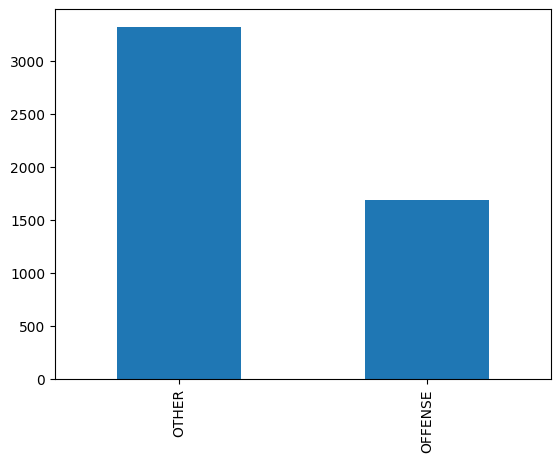

In [4]:
df.Primary_Category.value_counts().plot.bar()

<AxesSubplot: >

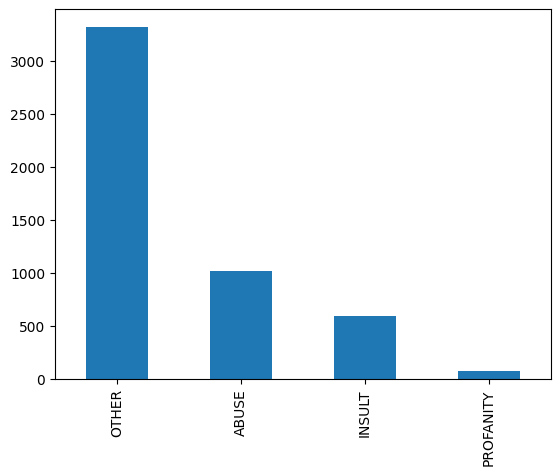

In [5]:
df.Secondary_Category.value_counts().plot.bar()

## Data Cleansing


In [6]:
import re

def retrieve_hashtags(text: str, regex = r"\B(\#[a-zA-Z_\-0-9]+\b)"):
    return re.findall(regex, text)

def remove_hashtags(text: str):
    return text.replace('#', '')



df['Hashtags'] = df.Tweet.progress_apply(retrieve_hashtags)
df.Tweet = df.Tweet.progress_apply(remove_hashtags)
df.head()

100%|██████████| 5009/5009 [00:00<00:00, 1250030.86it/s]


Tweet Primary_Category  \
0  @corinnamilborn Liebe Corinna, wir würden dich...            OTHER   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...            OTHER   
2  @ahrens_theo fröhlicher gruß aus der schönsten...            OTHER   
3  @dushanwegner Amis hätten alles und jeden gewä...            OTHER   
4  @spdde kein verläßlicher Verhandlungspartner. ...          OFFENSE   

  Secondary_Category Hashtags  
0              OTHER       []  
1              OTHER       []  
2              OTHER       []  
3              OTHER       []  
4             INSULT   [#SPD]

In [7]:
from HanTa import HanoverTagger as ht

tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [8]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatzer = WordNetLemmatizer()


def text_cleansing(text: str) -> str:
    # Tokenizing
    text_tokens = word_tokenize(text)
    # Lemmatising
    text_tokens_lemmatized = [tagger.analyze(
        token)[0] for token in text_tokens]
    return " ".join(text_tokens_lemmatized)


text_cleansing(
    "Hallo. Ich spielte am frühen Morgen und ging dann zu einem Freund. Auf Wiedersehen")


'Hallo -- ich spielen am früh morgen und gehen dann zu einem Freund -- auf Wiedersehen'

In [9]:
def retrieve_mentions(text: str, regex=r"\B(\@[a-zA-Z_\-0-9]+\b)"):
    return re.findall(regex, text)


def remove_mentions(text: str, regex=r"\B(\@[a-zA-Z_\-0-9]+\b)"):
    return re.sub(regex, '', text)


df['Mentions'] = df.Tweet.progress_apply(retrieve_mentions)
df.Tweet = df.Tweet.progress_apply(remove_mentions)
df.Tweet = df.Tweet.progress_apply(text_cleansing)
df.head()


100%|██████████| 5009/5009 [00:32<00:00, 155.40it/s]


Tweet Primary_Category  \
0  Liebe Corinna -- wir werden dich gerne als Mod...            OTHER   
1  sie haben ja auch Recht -- unser Tweet sein et...            OTHER   
2  fröhlich Gruß aus der schön Stadt der Welt The...            OTHER   
3  Amis haben alles und jeden wählen -- nur Hilla...            OTHER   
4  kein verläßlich Verhandlungspartner -- Nachkar...          OFFENSE   

  Secondary_Category Hashtags           Mentions  
0              OTHER       []  [@corinnamilborn]  
1              OTHER       []       [@Martin28a]  
2              OTHER       []     [@ahrens_theo]  
3              OTHER       []    [@dushanwegner]  
4             INSULT   [#SPD]           [@spdde]

In [10]:
client.schema.delete_all()

## Data Modelling


In [11]:
data_schema = {
    "classes": [
        {
            "class": "Tweet",
            "description": "A Twitter message",
            "properties": [
                {"name": "text","dataType": ["text"],"description": "Content of the Tweet"},
                {
                    "name": "primaryCategory",
                    "dataType": ["string"],
                    "description": "The primary category the Tweet was labeled"
                },
                {
                    "name": "secondaryCategory",
                    "dataType": ["string"],
                    "description": "The secondary category the Tweet was labeled"
                },
                {
                    "name": "hasHashtags",
                    "dataType": ["Hashtag"]
                },
                {
                    "name": "hasMentions",
                    "dataType": ["Mention"]
                }
            ],
            "replicationConfig": {
                "factor": 2
            },
            "shardingConfig": {
                "desiredCount": 1
            }
        },
        {
            "class": "Hashtag",
            "description": "A Hashtag used in Tweets",
            "properties": [
                {
                    "name": "text",
                    "dataType": ["string"],
                    "description": "Content of the Hashtag"
                },
                {
                    "name": "hasTweets",
                    "dataType": ["Tweet"]
                }
            ],
            "replicationConfig": {
                "factor": 2
            },
            "shardingConfig": {
                "desiredCount": 1
            }
        },
        {
            "class": "Mention",
            "description": "A user mentioned in a Tweet",
            "properties": [
                {
                    "name": "name",
                    "dataType": ["string"],
                    "description": "Name of the user"
                },
                {
                    "name": "hasTweets",
                    "dataType": ["Tweet"]
                }
            ],
            "replicationConfig": {
                "factor": 2
            },
            "shardingConfig": {
                "desiredCount": 1
            }
        }
    ]
}

In [12]:
try:
    client.schema.create(data_schema)
except:
    print('Schema already defined')
client.schema.get()


{'classes': [{'class': 'Tweet',
   'description': 'A Twitter message',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'moduleConfig': {'text2vec-transformers': {'poolingStrategy': 'masked_mean',
     'vectorizeClassName': True}},
   'properties': [{'dataType': ['text'],
     'description': 'Content of the Tweet',
     'moduleConfig': {'text2vec-transformers': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'text',
     'tokenization': 'word'},
    {'dataType': ['string'],
     'description': 'The primary category the Tweet was labeled',
     'moduleConfig': {'text2vec-transformers': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'primaryCategory',
     'tokenization': 'word'},
    {'dataType': ['string'],
     'description': 'The secondary category the Tweet was labeled',
     'moduleConfig': {'text2vec-transformers': {'s

In [13]:
from weaviate.util import generate_uuid5
hashtags = {}

client.batch.configure(20, dynamic=True)
with client.batch as batch:
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        for hashtag in row['Hashtags']:
            if hashtag not in hashtags:
                entry = {"text": hashtag}
                hashtag_uuid = generate_uuid5(entry, 'Hashtag')
                batch.add_data_object(
                    data_object=entry, class_name='Hashtag', uuid=hashtag_uuid)
                hashtags[hashtag] = hashtag_uuid


100%|██████████| 5009/5009 [00:21<00:00, 230.06it/s]


In [14]:
mentions = {}

client.batch.configure(20, dynamic=True)
with client.batch as batch:
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        for mention in row['Mentions']:
            if mention not in mentions:
                entry = {"name": mention}
                mention_uuid = generate_uuid5(entry, 'Mention')
                batch.add_data_object(
                    data_object=entry, class_name='Mention', uuid=mention_uuid)
                mentions[mention] = mention_uuid

100%|██████████| 5009/5009 [01:09<00:00, 72.38it/s] 


In [15]:
def add_tweet(batch: weaviate.batch.Batch, tweet: dict, hashtags: dict, mentions: dict) -> str:
    data_object = {
        "text": tweet["Tweet"],
        "primaryCategory": tweet["Primary_Category"],
        "secondaryCategory": tweet["Secondary_Category"]
    }
    tweet_uuid = generate_uuid5(data_object, 'Tweet')
    batch.add_data_object(data_object=data_object,
                          class_name="Tweet", uuid=tweet_uuid)

    for hashtag in tweet['Hashtags']:
        # Reference Tweet   --> Hashtag
        batch.add_reference(from_object_uuid=tweet_uuid, from_object_class_name='Tweet',
                            from_property_name='hasHashtags', to_object_uuid=hashtags[hashtag], to_object_class_name="Hashtag")
        # Reference Hashtag --> Tweet
        batch.add_reference(from_object_uuid=hashtags[hashtag], from_object_class_name='Hashtag',
                            from_property_name='hasTweets', to_object_uuid=tweet_uuid, to_object_class_name="Tweet")
    for mention in tweet['Mentions']:
        # Reference Tweet   --> Mention
        batch.add_reference(from_object_uuid=tweet_uuid, from_object_class_name='Tweet',
                            from_property_name='hasMentions', to_object_uuid=mentions[mention], to_object_class_name="Mention")
        # Reference Mention --> Tweet
        batch.add_reference(from_object_uuid=mentions[mention], from_object_class_name='Mention',
                            from_property_name='hasTweets', to_object_uuid=tweet_uuid, to_object_class_name="Tweet")

In [16]:
from tqdm import trange

client.batch.configure(20, dynamic=True)

with client.batch as batch:
    for i in trange(len(df)):
        add_tweet(batch, df.iloc[i], hashtags, mentions)


100%|██████████| 5009/5009 [08:06<00:00, 10.30it/s]


In [17]:
query = """
{
  Get {
    Tweet(limit: 2, where: {path: "primaryCategory", operator: Equal, valueString: "OTHER"}) {
      _additional{
        id
      }
      text
      hasMentions {
        ... on Mention {
          _additional{
            id
          }
          name
        }
      }
    }
  }
}
"""

response = client.query.raw(query)
tweet = response['data']['Get']['Tweet']
print(tweet)

entry_to_be_updated = tweet[0]
object_id = entry_to_be_updated['_additional']['id']


[{'_additional': {'id': '32a5077a-2c0a-5bf5-b5a9-ee67c386634b'}, 'hasMentions': [{'_additional': {'id': 'cf4b45a2-e7de-5631-b3d4-f16b8ac42d0a'}, 'name': '@jayxderxmensch'}, {'_additional': {'id': 'e2b3500b-4002-51b9-9b3b-dbb1f39b7725'}, 'name': '@jayxthexhuman'}], 'text': 'wieso -- was finden du da unklar --'}, {'_additional': {'id': '74d30983-ffa9-52e3-8010-3054bb55f61e'}, 'hasMentions': [{'_additional': {'id': '50dd5f6c-c8d0-5164-98e3-dc96c41b4402'}, 'name': '@Dirki_M'}], 'text': 'ja -- aber wo widersprechen die Zahl denn denen -- die im von uns verlinkt Artikel stehen -- in unser Tweet gehen es rein um Subs -- geschützt -- 2017 sein der gesamt Familiennachzug im Vergleich zu 2016 -- die Zahl -- die Hr -- Brandner bemühen -- übrigens leicht rückläufig sein --'}]


In [18]:
result = requests.patch(f"{WEAVIATE_URL}/v1/objects/Tweet/{object_id}", data=json.dumps({
                        "text": entry_to_be_updated["text"]}), headers={"Content-Type": "application/json"})
print(f"{result.status_code}: {result.text}")

where_filter = {"path": ["id"], "operator": "Equal", "valueString": object_id}
response = client.query.get("Tweet", ["text"]).with_where(where_filter).do()
print(response)

204: 
{'data': {'Get': {'Tweet': [{'text': 'wieso -- was finden du da unklar --'}]}}}


In [19]:
# Delete an entry
# object_id = entry_to_be_updated['hasMentions'][0]["_additional"]["id"]
# print(object_id)
# result = requests.delete(f"{WEAVIATE_URL}/v1/objects/Mention/{object_id}")
# print(f"{result.status_code}: {result.text}")

## Inference & Testing


In [20]:
df_test = pd.read_csv("./data/germeval2018.test.txt", delimiter="\t",
                      header=None, names=["Tweet", "Primary_Category", "Secondary_Category"])
df_test.Tweet = df_test.Tweet.progress_apply(remove_mentions)
df_test.Tweet = df_test.Tweet.progress_apply(remove_hashtags)
df_test.Tweet = df_test.Tweet.progress_apply(text_cleansing)
df_test.head()


100%|██████████| 3398/3398 [00:18<00:00, 184.41it/s]


Tweet Primary_Category  \
0  mein Mutter haben mir erzählen -- dass mein Va...            OTHER   
1  mein Reaktion -- |lbr| nicht jeder Moslem sein...            OTHER   
2  Merkel rollen dem Emir von Katar -- der islami...            OTHER   
3  „ merlen sein kein jung unschuldig Mädchen “ K...            OTHER   
4  Asylantenflut bringen eben nur negativ für Deu...          OFFENSE   

  Secondary_Category  
0              OTHER  
1              OTHER  
2              OTHER  
3              OTHER  
4              ABUSE

In [21]:
def predict_near_text(client: weaviate.client, text:str, certainty:float=0.75) -> tuple:
    """Perform a classification on given text.

    Args:
        client (weaviate.client): Weaviate client instance connected to the cluster
        text (str): Text to be classified
        certainty (float, optional): _description_. Defaults to 0.65.

    Returns:
        tuple: (primary_category, secondary_category)
    """
    weaviate_result = client.query.get(class_name='Tweet', properties=["primaryCategory", "secondaryCategory"]).with_limit(
        1).with_near_text({"concepts": [text], "certainty": certainty}).do()

    tweets = weaviate_result['data']['Get']['Tweet']
    if len(tweets) > 0:
        predicted_primary = tweets[0]['primaryCategory']
        predicted_secondary = tweets[0]['secondaryCategory']
        return (predicted_primary, predicted_secondary)
    return None

result = predict_near_text(client, "Es war einmal") 
print(result)

None


In [22]:
def predict_hybrid(client: weaviate.client, text:str, alpha: float=0.5) -> tuple:
    """Perforam a hybrid search based classification on given text.

    Args:
        client (weaviate.client): Weaviate client instance connected to the cluster
        text (str): Text to be classified
        alpha (float, optional): weighting for each search algorithm (alpha = 0 (sparse), alpha = 1 (dense). Defaults to 0.5.

    Returns:
        tuple: (primary_category, secondary_category)
    """
    ab  = 2
    query = """
        {{
            Get {{
                Tweet(
                    hybrid: {{
                        query: "{0}"
                        alpha: {1}
                    }})
                {{
                    _additional {{
                        score
                    }}
                    primaryCategory
                    secondaryCategory
                }}
            }}
        }}
    """.format(text, alpha)
    weaviate_result = client.query.raw(query)

    tweets = weaviate_result['data']['Get']['Tweet']
    if len(tweets) > 0:
        predicted_primary = tweets[0]['primaryCategory']
        predicted_secondary = tweets[0]['secondaryCategory']
        return (predicted_primary, predicted_secondary)
    return None

predict_hybrid(client, "Hello World")

('OTHER', 'OTHER')

In [23]:
def run_test_data(predict_method, param: float):

    correct_predictions_primary = 0
    false_predictions_primary = 0

    correct_predictions_secondary = 0
    false_predictions_secondary = 0

    no_result = 0

    for i in trange(len(df_test)):
        entry = df_test.iloc[i]
        try:
            prediction = predict_method(client, entry.Tweet, param)
            if prediction != None:
                (predicted_primary, predicted_secondary) = prediction
                if predicted_primary == entry['Primary_Category']:
                    correct_predictions_primary += 1
                else:
                    false_predictions_primary += 1

                if predicted_secondary == entry['Secondary_Category']:
                    correct_predictions_secondary += 1
                else:
                    false_predictions_secondary += 1    
            else:
                no_result += 1
        except Exception as e:
            print(f"Error at Index: {i}")

    return {
        "accuracy_primary": round(correct_predictions_primary/(correct_predictions_primary+false_predictions_primary)*100,2),
        "accuracy_secondary": round(correct_predictions_secondary/(correct_predictions_secondary+false_predictions_secondary)*100,2),
        "not_found": no_result
    }


In [24]:
certainties = [0.5, 0.65, 0.75, 0.9]
results = []
for certainty in certainties:
    accuracy = run_test_data(predict_near_text, certainty)
    results.append(accuracy)
results_near_text = pd.DataFrame(data=results, index=certainties)
results_near_text.index.name = "certainty"
results_near_text.head()

100%|██████████| 3398/3398 [04:15<00:00, 13.32it/s]


accuracy_primary  accuracy_secondary  not_found
certainty                                                 
0.50                  66.04               65.92          0
0.65                  66.04               65.92          0
0.75                  65.95               65.86         35
0.90                  80.82               80.82       3179

In [25]:
alphas = [0, 0.25, 0.5, 0.75, 1]
results = []
for alpha in alphas:
    accuracy = run_test_data(predict_hybrid, alpha)
    results.append(accuracy)
results_hybrid = pd.DataFrame(data=results, index=alphas)
results_hybrid.index.name = "alpha"
results_hybrid.head()

100%|██████████| 3398/3398 [04:17<00:00, 13.21it/s]


accuracy_primary  accuracy_secondary  not_found
alpha                                                 
0.00              63.89               59.01          0
0.25              65.72               64.10          0
0.50              66.07               65.72          0
0.75              66.01               65.86          0
1.00              65.98               65.83          0